# ClimateNet AR Analysis: ARTMIP comparisons

In [177]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl
from labellines import labelLine, labelLines

In [121]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
# 5 GB was fine for western US but ran into memory issues for western Europe (needed 20 GB)...due to extra rolling step to fix lons?
nmem1 = '5GiB' # PBSCluster specification
nmem2 = '5GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44949 instead
  warnings.warn(
/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/bokeh/application/application.py:165: RuntimeWarning: coroutine 'WSHandler.send_message' was never awaited
  static_paths = {h.static_path() for h in self.handlers}


In [122]:
client

<Client: 'tcp://128.117.208.98:32883' processes=10 threads=10, memory=50.00 GiB>

## Set ClimateNet filepath

In [123]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

## Set regional bounds

In [124]:
# Selected transects along the North American West Coast (Rutz et al. 2019)
lat_bounds = slice(32,55)
lon_bounds = slice(230,255)

# Western Europe
#lat_bounds = slice(35,62) # Might even adjust down to 60N based on Fig. 4 of Rutz et al.
#lon_bounds = slice(-20,10) # Roll lons!
#lon_bounds = slice(345, 360) # visually it looks like Rutz et al. stops at 0E even though the NCL code uses 10E. In this case I wouldn't have to roll lons. Rutz et al. also mentions 15W as western boundary.

### Preprocessing function to subset regionally

In [125]:
def preprocess_region(ds):
    # return regional domain

    # rolling for western Europe slice crossing meridian
    #ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    #ds = ds.roll(lon=int(len(ds['lon']) / 2), roll_coords=True)
    
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

## Read in landfrac for this grid
To subset land points

In [126]:
landfrac_file = "/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.regrid_0.23x0.31.nc"
landfrac_ds = xr.open_dataset(landfrac_file)

# rolling for western Europe slice
#landfrac_ds = landfrac_ds.assign_coords(lon=(((landfrac_ds.lon + 180) % 360) - 180))
#landfrac_ds = landfrac_ds.roll(lon=int(len(landfrac_ds['lon']) / 2), roll_coords=True)

landfrac = landfrac_ds.LANDFRAC.sel(lat=lat_bounds,lon=lon_bounds)

In [127]:
landfrac

<xarray.DataArray 'LANDFRAC' (lat: 98, lon: 81)>
[7938 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
Attributes:
    long_name:      gridbox land fraction
    cell_measures:  area: area

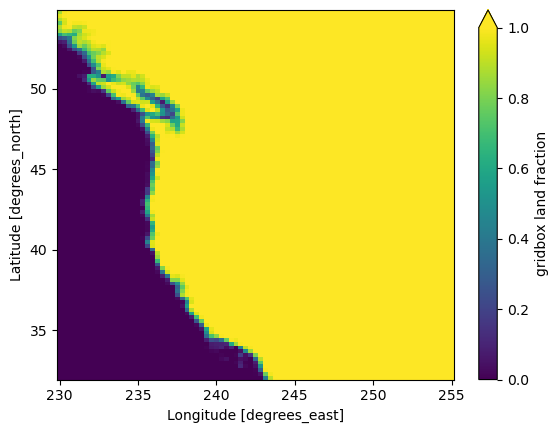

In [128]:
landfrac.plot(robust=True);

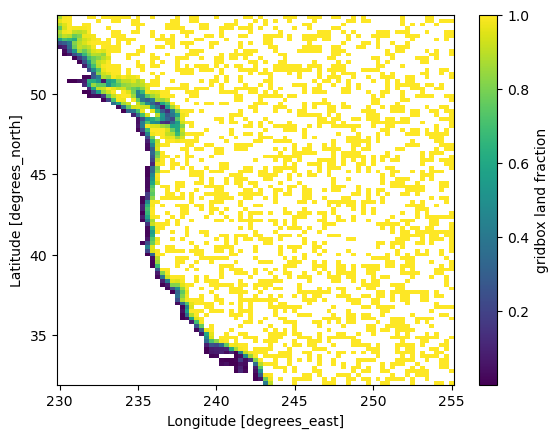

In [129]:
landfrac.where((landfrac > 0) & (landfrac < 1)).plot();

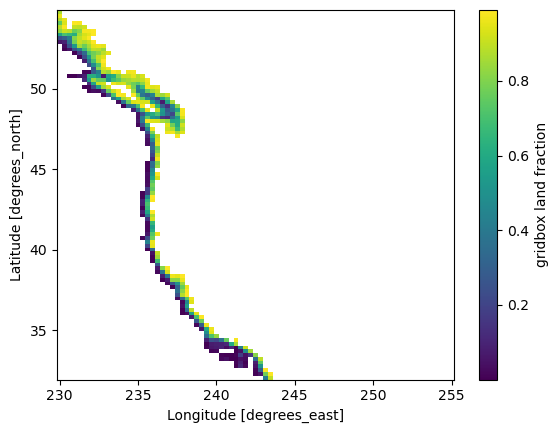

In [130]:
landfrac.where((landfrac > 0) & (landfrac < 0.99)).plot();

## CESM historical simulation

In [131]:
hist_yrs = [str(i) for i in range(2000,2006)]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [132]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
#hist_paths

### Read in masks with preprocessing

In [133]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 1.79 s, sys: 153 ms, total: 1.95 s
Wall time: 26.7 s


In [134]:
cnet_hist_shift

<xarray.DataArray 'masks' (time: 17520, lat: 98, lon: 81)>
dask.array<concatenate, shape=(17520, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [129]:
# OPTIONAL: persist for W Euro calcs with rolling lons (why does it add so much to the dask task graph?)
#cnet_hist_shift = cnet_hist_shift.persist() # could also persist after timeshift

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [135]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")
#timeshift

In [136]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
cnet_hist

<xarray.DataArray 'masks' (time: 17520, lat: 98, lon: 81)>
dask.array<concatenate, shape=(17520, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## CESM RCP2.6 simulation

In [137]:
rcp26_yrs = [str(i) for i in range(2006,2016)]
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # unweighted means/std

In [138]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp26_paths = [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
#rcp26_paths

### Read in masks with preprocessing

In [139]:
%%time
cnet_rcp26 = xr.open_mfdataset(rcp26_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 683 ms, sys: 56.4 ms, total: 740 ms
Wall time: 9.1 s


In [140]:
cnet_rcp26

<xarray.DataArray 'masks' (time: 29200, lat: 98, lon: 81)>
dask.array<concatenate, shape=(29200, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.BRCP26C5CN.ne120_g16.003
    ...                         ...
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/p/cgd/amp/jet/mapfiles/map_ne120_to_dl...
    input_file:                 /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    history_of_appended_files:  Mon Apr  3 10:28:39 2023: Appended file 2006_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [134]:
# OPTIONAL: persist for W Euro calcs with rolling lons (why does it add so much to the dask task graph?)
#cnet_rcp26 = cnet_rcp26.persist()

## Combine historical/RCP2.6

In [141]:
cnet_hist_rcp26 = xr.concat([cnet_hist, cnet_rcp26], dim='time')
cnet_hist_rcp26

<xarray.DataArray 'masks' (time: 46720, lat: 98, lon: 81)>
dask.array<concatenate, shape=(46720, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## Persist to make the following calcs faster
If not already done above

In [142]:
cnet_hist_rcp26 = cnet_hist_rcp26.persist()

## Define ARs

In [143]:
AR = cnet_hist_rcp26.clip(min=1)-1
AR

<xarray.DataArray 'masks' (time: 46720, lat: 98, lon: 81)>
dask.array<sub, shape=(46720, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00

## Counts at coastline
Using `artmip_countsbylat_xy.env.ncl` and `plot_artmip_countsbylat_newmethod_xy.ncl` from C. Shields as a starting point

### ARcount over time at each gridpoint

In [22]:
ARcount = AR.sum(dim='time')
#ARcount.plot();

### Select for fractional land/sea points

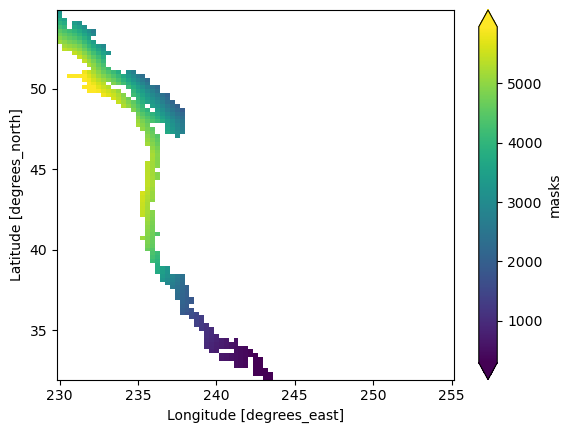

In [23]:
#ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 1)) 
ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.99)) # upper bound chosen to account for weird behavior in landfrac max when using upper bound < 1
ARcount_frac.plot(robust=True);

In [24]:
ARcount_frac

<xarray.DataArray 'masks' (lat: 98, lon: 81)>
dask.array<where, shape=(98, 81), dtype=float64, chunksize=(98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8

### Debugging - check individual plots

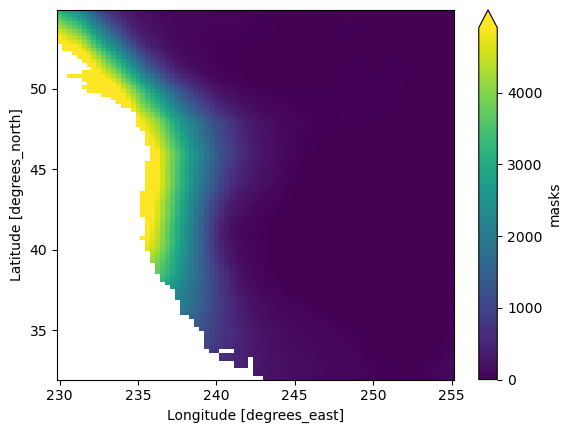

In [49]:
ARcount.where(landfrac > 0).plot(robust=True);

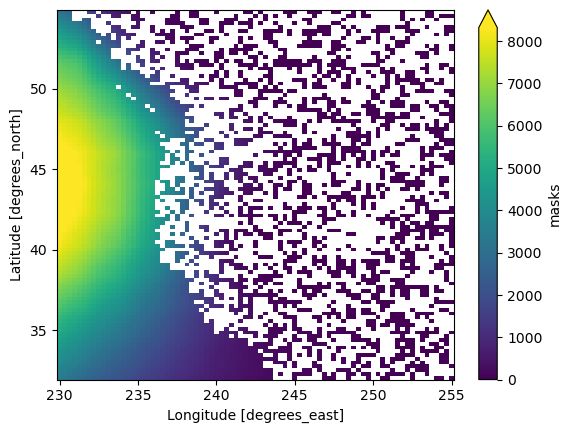

In [50]:
ARcount.where(landfrac < 1).plot(robust=True);

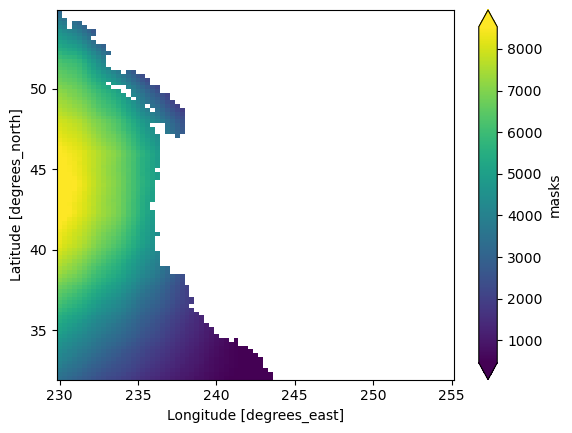

In [51]:
# it's a weird rounding thing!! something with interpreting landfrac
ARcount.where(landfrac < 0.99).plot(robust=True);

### Average across longitudes at each latitude
Why not sum / total time points for frequency?\
There aren't that many longitudes included once you select for fractional land/sea points

In [25]:
ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
#ARcount_frac_zmean.plot();

### Frequency calculation

Text(0.5, 1.0, 'Counts at Coastlines, CESM Historical (2000-2015)\nWestern North America')

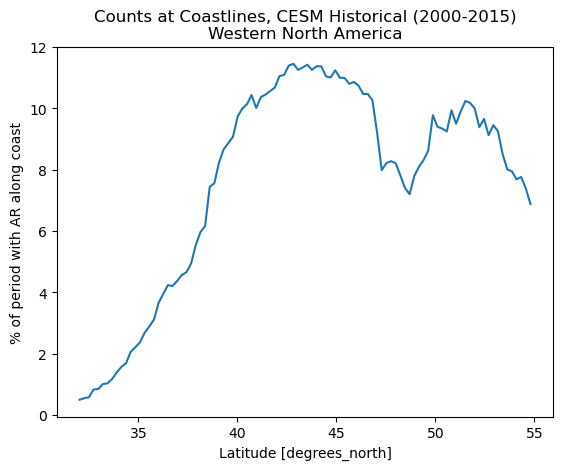

In [29]:
ARfreq_frac_zmean = 100*(ARcount_frac_zmean / len(AR.time))
ARfreq_frac_zmean.plot()
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, CESM Historical (2000-2015)\nWestern North America');
#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26.png');

#plt.title('Counts at Coastlines, CESM Historical (2000-2015)\nWestern Europe')
#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WEuro_CESM_hist_rcp26.png');

### Testing - try the total at each latitude instead of the average

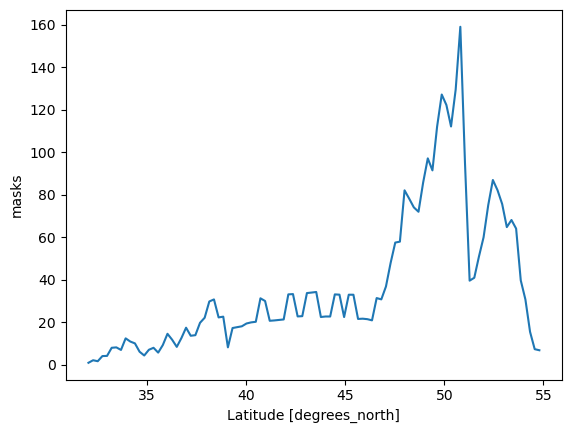

In [24]:
(100 * (ARcount_frac.sum(dim='lon', skipna=True) / len(AR.time))).plot();

### Function for easier use

In [144]:
def counts_at_coastlines(AR, landfrac):
    ARcount = AR.sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.99))
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean = 100*(ARcount_frac_zmean / len(AR.time))
    return(ARfreq_frac_zmean)

In [145]:
ARfreq_frac_zmean = counts_at_coastlines(AR, landfrac)

## CESM RCP8.5 simulation

In [146]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85_yrs] # RCP8.5 data used to calculate means/std in config file (unweighted)

In [147]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file for i,f in enumerate(rcp85_folders)]

### Read in masks with preprocessing

In [148]:
%%time
cnet_rcp85 = xr.open_mfdataset(rcp85_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 783 ms, sys: 201 ms, total: 984 ms
Wall time: 4.66 s


In [149]:
cnet_rcp85

<xarray.DataArray 'masks' (time: 43800, lat: 98, lon: 81)>
dask.array<concatenate, shape=(43800, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

In [150]:
cnet_rcp85 = cnet_rcp85.persist()

In [151]:
AR_rcp85 = cnet_rcp85.clip(min=1)-1

In [152]:
ARfreq_frac_zmean_rcp85 = counts_at_coastlines(AR_rcp85, landfrac)
ARfreq_frac_zmean_rcp85

<xarray.DataArray 'masks' (lat: 98)>
dask.array<mul, shape=(98,), dtype=float64, chunksize=(98,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8

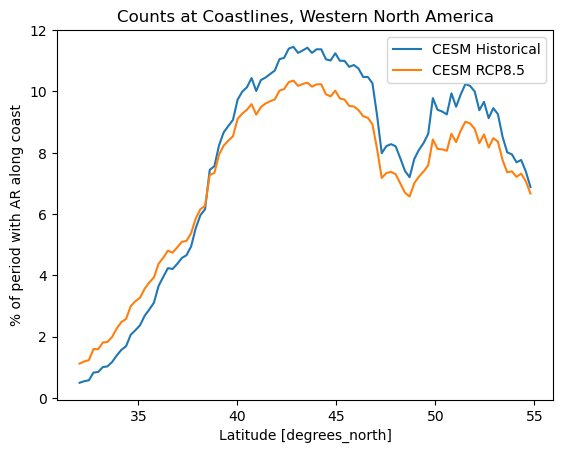

In [77]:
ARfreq_frac_zmean.plot(label='CESM Historical')
ARfreq_frac_zmean_rcp85.plot(label='CESM RCP8.5')

plt.legend()

plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, Western North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26_rcp85.png');

## MERRA2

In [153]:
merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier1/ClimateNet_DL/' # tier1, 3hrly
#merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier2/MERRA2_native/climatenet/' # tier2, 1hrly

In [154]:
file_years = '*.20[00-15]*' # not a perfect wildcard, but captures 2000 - 2017 (or 2019 for tier2)
#file_years = '*.nc4' # for all years; 1980 - June 2017

### Preprocessing function to subset regionally

In [155]:
# MERRA2 lons are -180 / +180
lat_bounds_merra = slice(32,55)
lon_bounds_merra = slice(-130,-105)

In [156]:
def preprocess_region_merra(ds):
    # return regional domain
    return ds['ar_binary_tag'].sel(lat=lat_bounds_merra,lon=lon_bounds_merra)

## Read in data

In [157]:
%%time
merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region_merra)

CPU times: user 98.8 ms, sys: 16.5 ms, total: 115 ms
Wall time: 590 ms


In [158]:
merra_ar_full = merra_cnet
merra_ar_full

<xarray.DataArray 'ar_binary_tag' (time: 51128, lat: 47, lon: 41)>
dask.array<concatenate, shape=(51128, 47, 41), dtype=int8, chunksize=(500, 47, 41), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 32.5 33.0 33.5 34.0 ... 53.0 53.5 54.0 54.5 55.0
  * lon      (lon) float32 -130.0 -129.4 -128.8 -128.1 ... -106.2 -105.6 -105.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2017-06-30T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

In [159]:
# subset 2000-2015 to match CESM years (number of time indices will not match due to CESM shifted start and MERRA leap years)
merra_ar = merra_ar_full.sel(time=slice("2000","2015"))

# or look at all years
#merra_ar = merra_ar_full

merra_ar

<xarray.DataArray 'ar_binary_tag' (time: 46752, lat: 47, lon: 41)>
dask.array<getitem, shape=(46752, 47, 41), dtype=int8, chunksize=(500, 47, 41), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 32.5 33.0 33.5 34.0 ... 53.0 53.5 54.0 54.5 55.0
  * lon      (lon) float32 -130.0 -129.4 -128.8 -128.1 ... -106.2 -105.6 -105.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

In [160]:
merra_ar = merra_ar.persist()

### Read in MERRA2 landfrac
Actually stored as 'ocnfrac'\
CGD machines: /project/ccr/shields/merra2/merra2_ocn_land_fraction.nc\
CISL machines: /glade/derecho/scratch/shields/ARTMIP/grids/merra2_ocn_land_fraction.nc 

In [161]:
merra_landfrac_file = "/glade/derecho/scratch/shields/ARTMIP/grids/merra2_ocn_land_fraction.nc"
merra_landfrac_ds = xr.open_dataset(merra_landfrac_file)
#merra_landfrac_ds

In [163]:
merra_landfrac = 1-(merra_landfrac_ds.ocnfrac.sel(lat=lat_bounds_merra,lon=lon_bounds_merra))
#merra_landfrac

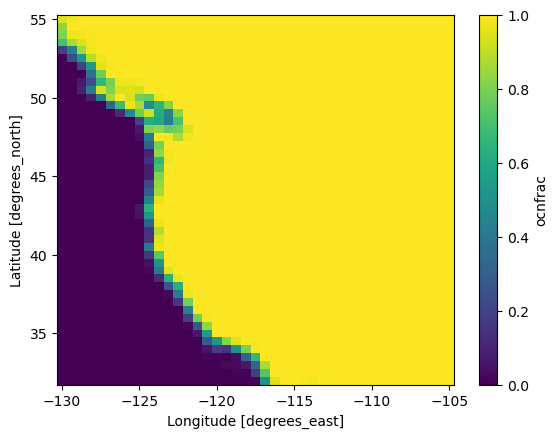

In [164]:
merra_landfrac.plot();

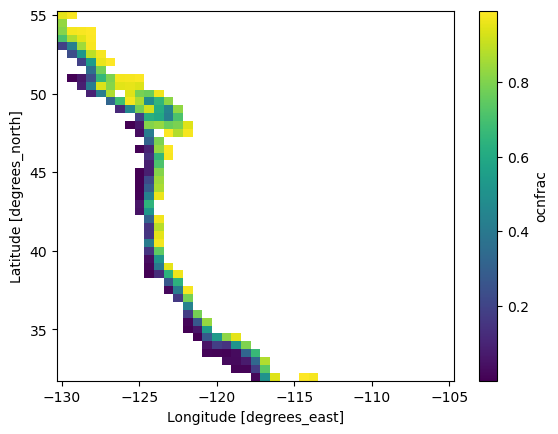

In [165]:
#merra_landfrac.where((merra_landfrac > 0) & (merra_landfrac < 1)).plot(); # no need to mess with bounds here
merra_landfrac.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).plot(); # check for using the same function

In [166]:
ARfreq_frac_zmean_merra = counts_at_coastlines(merra_ar, merra_landfrac)
ARfreq_frac_zmean_merra

<xarray.DataArray 'ar_binary_tag' (lat: 47)>
dask.array<mul, shape=(47,), dtype=float64, chunksize=(47,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 32.5 33.0 33.5 34.0 ... 53.0 53.5 54.0 54.5 55.0

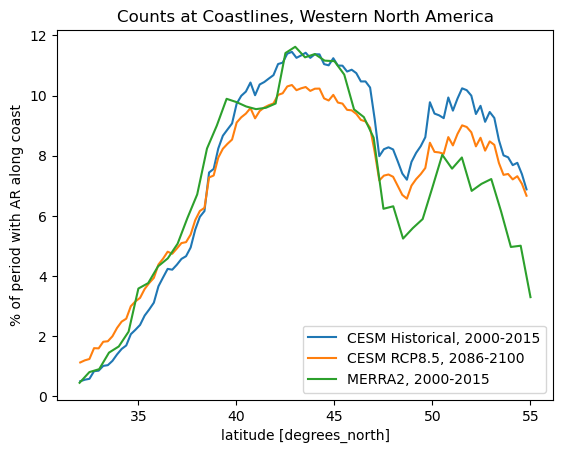

In [167]:
ARfreq_frac_zmean.plot(label='CESM Historical, 2000-2015')
ARfreq_frac_zmean_rcp85.plot(label='CESM RCP8.5, 2086-2100')
ARfreq_frac_zmean_merra.plot(label='MERRA2, 2000-2015')

plt.legend()

plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, Western North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26_rcp85_merra.png');

## Counts by Month

In [168]:
def counts_at_coastlines_month(AR, landfrac):
    ARcount = AR.groupby('time.month').sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.99))
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean_bymonth = 100*(ARcount_frac_zmean / AR.time.groupby('time.month').count())
    return(ARfreq_frac_zmean_bymonth)

In [169]:
ARfreq_frac_zmean_bymonth = counts_at_coastlines_month(AR, landfrac)
ARfreq_frac_zmean_bymonth

<xarray.DataArray (month: 12, lat: 98)>
dask.array<mul, shape=(12, 98), dtype=float64, chunksize=(1, 98), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

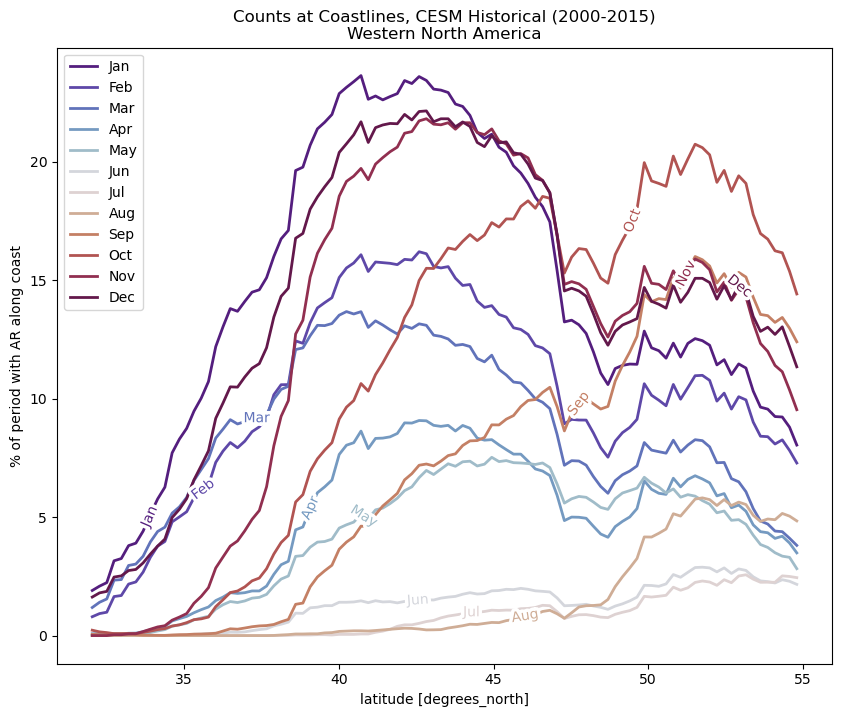

In [182]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))
#cm = plt.cm.Set3(np.linspace(0, 1, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_bymonth.lat, ARfreq_frac_zmean_bymonth.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, CESM Historical (2000-2015)\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26_bymonth_labels.png');

In [113]:
ARfreq_frac_zmean_rcp85_bymonth = counts_at_coastlines_month(AR_rcp85, landfrac)

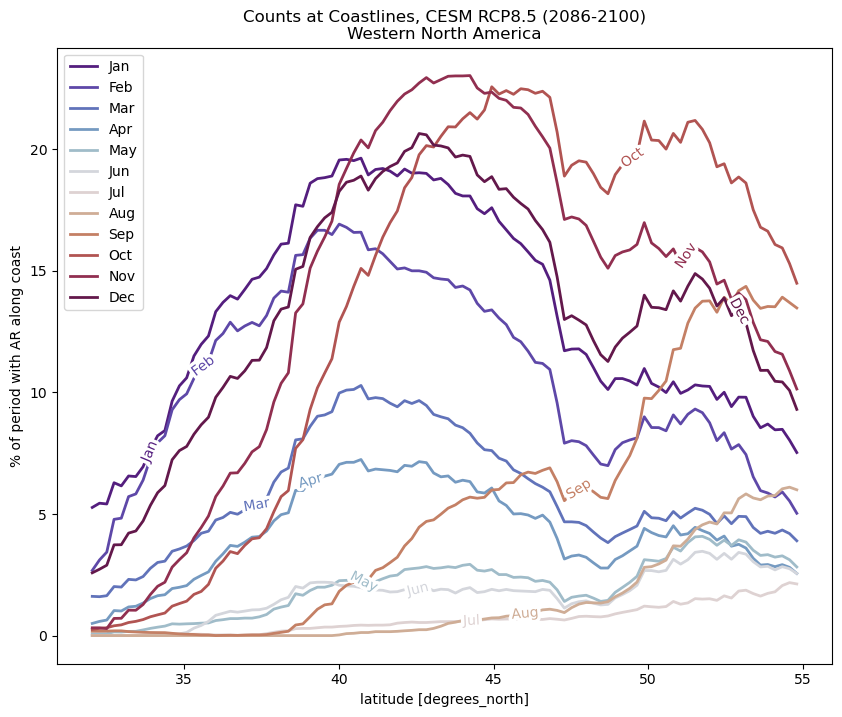

In [184]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_rcp85_bymonth.lat, ARfreq_frac_zmean_rcp85_bymonth.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, CESM RCP8.5 (2086-2100)\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_rcp85_bymonth_labels.png');

In [187]:
# CESM diff
ARfreq_frac_zmean_cesm_bymonth_diff = ARfreq_frac_zmean_rcp85_bymonth - ARfreq_frac_zmean_bymonth

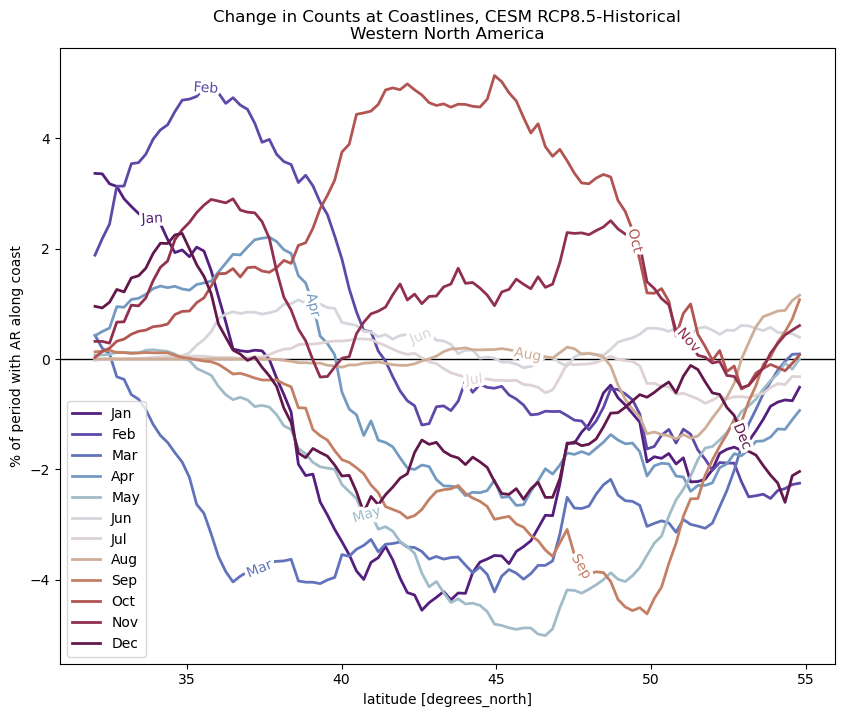

In [194]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_cesm_bymonth_diff.lat, ARfreq_frac_zmean_cesm_bymonth_diff.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.axhline(y=0, color='k', linewidth=1, zorder=0)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Change in Counts at Coastlines, CESM RCP8.5-Historical\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_diff_bymonth_labels.png');

In [116]:
ARfreq_frac_zmean_merra_bymonth = counts_at_coastlines_month(merra_ar, merra_landfrac)
ARfreq_frac_zmean_merra_bymonth

<xarray.DataArray (month: 12, lat: 47)>
dask.array<mul, shape=(12, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 32.5 33.0 33.5 34.0 ... 53.0 53.5 54.0 54.5 55.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

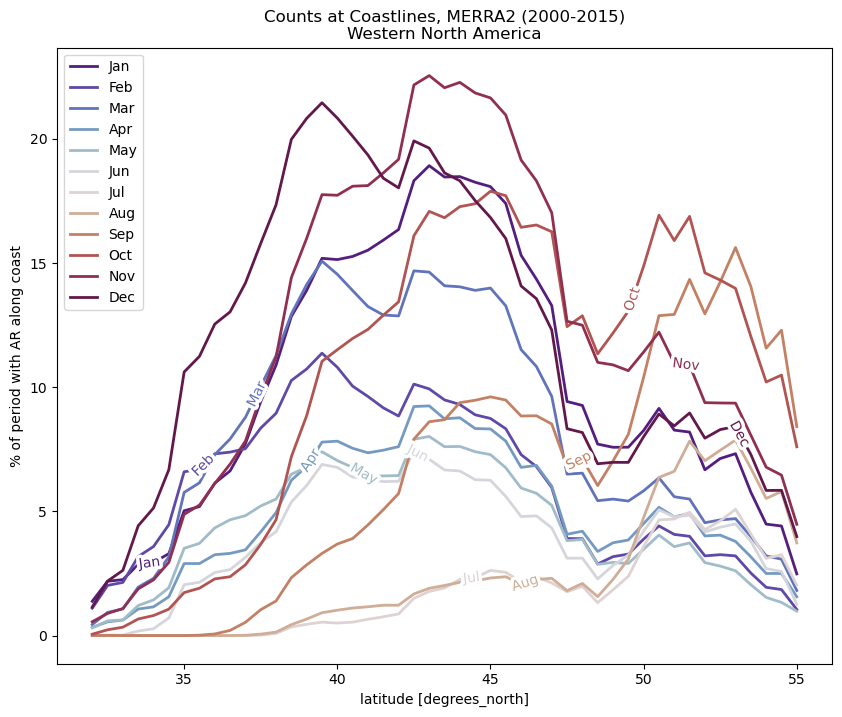

In [186]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_merra_bymonth.lat, ARfreq_frac_zmean_merra_bymonth.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, MERRA2 (2000-2015)\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_merra_bymonth_labels.png');

### Difference plot between CESM historical and MERRA
This doesn't work out of the box due to different horizontal resolutions\
TO DO: remap CESM hist to MERRA grid?

In [197]:
# CESM hist - MERRA <---- This diff doesn't work with different latitude resolutions
ARfreq_frac_zmean_cesm_merra_bymonth_diff = ARfreq_frac_zmean_bymonth - ARfreq_frac_zmean_merra_bymonth
ARfreq_frac_zmean_cesm_merra_bymonth_diff

<xarray.DataArray (month: 12, lat: 0)>
dask.array<sub, shape=(12, 0), dtype=float64, chunksize=(1, 0), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

ValueError: min() arg is an empty sequence

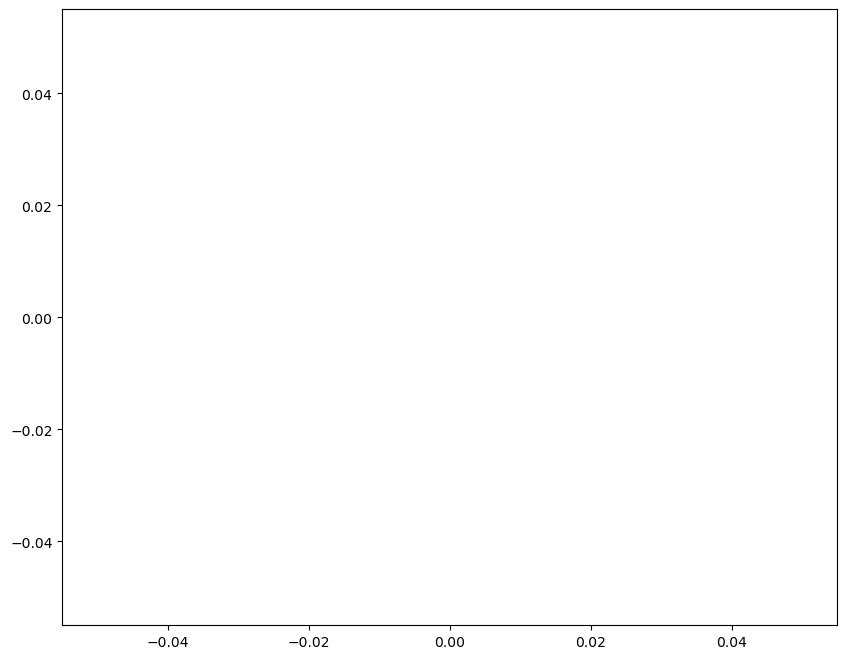

In [196]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_cesm_merra_bymonth_diff.lat, ARfreq_frac_zmean_cesm_merra_bymonth_diff.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.axhline(y=0, color='k', linewidth=1, zorder=0)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Change in Counts at Coastlines, CESM Historical - MERRA2\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_diff_bymonth_labels.png');

## Storm Duration
Using `artmip_stormdur_countsbylat_env.ncl` and `plot_artmip_countsbylat_dur.ncl`.

It looks like the ncl code relies on an external function(?) that I don't know how to parse:\
`external ar_stormcount_artmip "/fs/cgd/home0/shields/csm/ncl/wrappers/lib/ar_stormcount_artmip.so"`

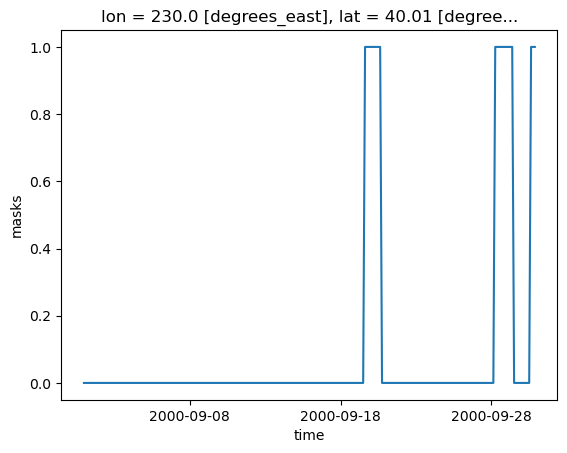

In [30]:
test_slice = AR.sel(lat=40, lon=230, method='nearest').sel(time=slice('2000-09-01','2000-09-30'))
test_slice.plot();

In [31]:
# I think what I need to do is look for consecutive 1's at each gridpoint over some time period
# Rutz et al. uses >= 12 hrs for AR event so that would be at least 5 consecutive 1's?
# Then keep track of the duration of those events so count the total # of 1's greater than or equal to 5 in a row
test_slice.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [32]:
# this is resampling to 12 hour periods and summing over those values
test_slice.resample(time='12h').sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 4, 0, 0, 3])

In [33]:
# this is looking at rolling 5-time point periods and summing them
# so once you get a "5" that means there has been an event
# and consecutive 5's tells you something about the event duration
# for example 5 consecutive 5's represents a 24-hr event, and 6 represents a 27-hr event
test_slice.rolling(time=5).sum().values

array([nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  5.,  5.,
        5.,  5.,  4.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [198]:
client.close()
cluster.close()